In [39]:

import os,sys
root_dir=os.path.abspath(os.path.join(os.getcwd(),'..'))
sys.path.append(root_dir)

import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

from models.utils.discriminativ_loss import combined_loss
from models.FCN import ResNet,BasicBlock
from data.FER2013 import FER2013
from data.utils import merger,augmentations

from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from torchvision import transforms as tf

Initalizing FER2013 dataset for train split
Emotion classes: ['neutral', 'angry', 'sad', 'surprise', 'disgust', 'fear', 'happy']
Number of images in each class: {'neutral': 4965, 'angry': 3995, 'sad': 4830, 'surprise': 3171, 'disgust': 436, 'fear': 4097, 'happy': 7215}
Total number of images: 28709
Total size of dataset: 0.04 GB
Initalizing FER2013 dataset for test split
Emotion classes: ['neutral', 'angry', 'sad', 'surprise', 'disgust', 'fear', 'happy']
Number of images in each class: {'neutral': 1233, 'angry': 958, 'sad': 1247, 'surprise': 831, 'disgust': 111, 'fear': 1024, 'happy': 1774}
Total number of images: 7178
Total size of dataset: 0.01 GB
torch.Size([64, 1, 64, 64]) torch.Size([64, 7])


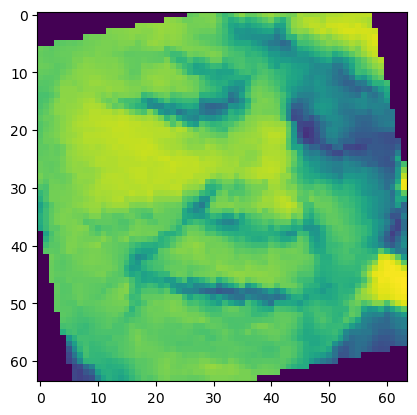

In [45]:
train_transform =tf.Compose([tf.Resize((64,64)),
                                   tf.Grayscale(),
                                   tf.RandomHorizontalFlip(p=0.5),
                                   tf.RandomRotation(degrees=25),
                                   tf.ToTensor(),
                                   tf.RandomErasing(0.5, scale=(0.02, 0.08), ratio=(0.3, 3.0))])
test_transform = augmentations.init_transforms(None)['test']
traindataset = FER2013(transform=train_transform,split='train')
testdataset = FER2013(transform=test_transform,split='test')
traindataloader,testdataloader = DataLoader(traindataset,batch_size=64,shuffle=True),DataLoader(testdataset,batch_size=64,shuffle=False)

# test the dataloader
for i,(data,label) in enumerate(traindataloader):
    print(data.shape,label.shape)
    plt.imshow(data[0].permute(1,2,0))
    break

In [35]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ResNet(block=BasicBlock,layers=[2,2,2,2],output_dim=7)
model.to(device)
loss_fn=combined_loss(feature_dim=128,num_classes=7)


for epoch in tqdm(range(50)):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    train_correct = 0
    for i, (inputs, targets) in enumerate(tqdm(traindataloader, total=len(traindataloader))):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        features,outputs = model(inputs)
        loss = loss_fn(features,outputs,targets)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        _, targets = torch.max(targets, 1)
        train_correct += (predicted == targets).sum().item()
    print(f'Epoch {epoch} Train Accuracy: {train_correct / len(traindataset)}')
        
    scheduler.step()
    model.eval()
    correct = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(tqdm(testdataloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            _, outputs = model(inputs)
            
            # both outputs and targets are one-hot encoding
            _, predicted = torch.max(outputs, 1)
            _, targets = torch.max(targets, 1)
            correct += (predicted == targets).sum().item()
    print(f'Epoch {epoch} Test Accuracy: {correct / len(testdataset)}')



/tmp/ipykernel_65780/956660359.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(50)):


  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_65780/956660359.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (inputs, targets) in enumerate(tqdm(traindataloader, total=len(traindataloader))):


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch 0 Train Accuracy: 0.22400640913999095


/tmp/ipykernel_65780/956660359.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (inputs, targets) in enumerate(tqdm(testdataloader)):


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 0 Test Accuracy: 0.1518528838116467


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch 1 Train Accuracy: 0.21317356926399386


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 1 Test Accuracy: 0.13346336026748398


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch 2 Train Accuracy: 0.21498484795708664


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 2 Test Accuracy: 0.2467261075508498


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch 3 Train Accuracy: 0.21512417708732454


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 3 Test Accuracy: 0.24212872666480914


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch 4 Train Accuracy: 0.21244209133024486


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 4 Test Accuracy: 0.18027305656171635


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch 5 Train Accuracy: 0.2317740081507541


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 5 Test Accuracy: 0.18361660629701868


  0%|          | 0/449 [00:00<?, ?it/s]

KeyboardInterrupt: 